# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
import imblearn
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier


In [2]:
data = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df = data.copy()
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking




Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [7]:
# Lets convert flight hour into periods of the day i.e morning afternooon and night
def segment_flight_hour(hour):
    if 5 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

In [8]:
df['period_of_day'] = df.apply(lambda x: segment_flight_hour(x.flight_hour), axis = 1)
df = df.drop(["flight_hour", 'route'], axis = 1)
df.period_of_day.value_counts()

Morning      21519
Afternoon    13749
Night        13333
Evening       1399
Name: period_of_day, dtype: int64

In [9]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


C:\Users\elegb\AppData\Local\Temp\ipykernel_16456\4186578139.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


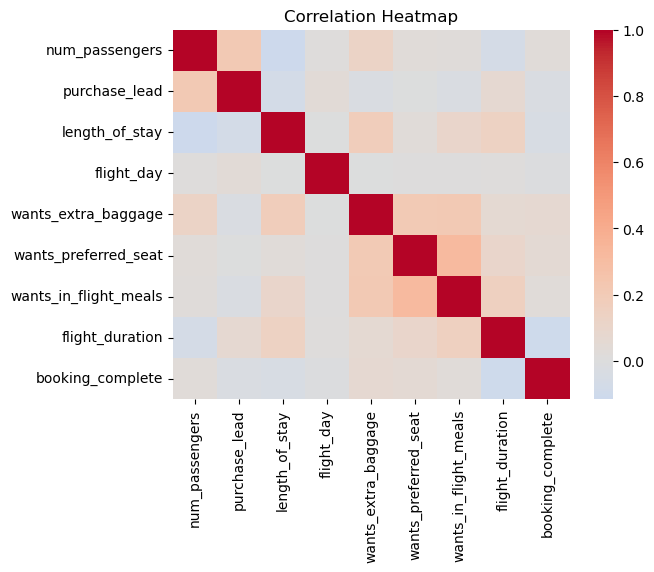

In [10]:
correlation = df.corr()
sns.heatmap(correlation, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [11]:
#check for missing values
df.isna().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_day               0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
period_of_day            0
dtype: int64

In [12]:
# Dropping duplicate rows
df = df.drop_duplicates().reset_index().drop(columns = 'index', axis =1)
df.shape

(49025, 13)

In [13]:
# check for data types and correct wrong ones
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_day                 int64
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
period_of_day             object
dtype: object

In [14]:
df.booking_origin.value_counts()

Australia               17609
Malaysia                 7030
South Korea              4472
Japan                    3803
China                    3253
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: booking_origin, Length: 104, dtype: int64

In [15]:
# There are a whole lot of unique values in the booking origin column, so lets try to bin it into continents
df.booking_origin.unique()

array(['New Zealand', 'India', 'United Kingdom', 'China', 'South Korea',
       'Japan', 'Malaysia', 'Singapore', 'Switzerland', 'Germany',
       'Indonesia', 'Czech Republic', 'Vietnam', 'Thailand', 'Spain',
       'Romania', 'Ireland', 'Italy', 'Slovakia', 'United Arab Emirates',
       'Tonga', 'Réunion', '(not set)', 'Saudi Arabia', 'Netherlands',
       'Qatar', 'Hong Kong', 'Philippines', 'Sri Lanka', 'France',
       'Croatia', 'United States', 'Laos', 'Hungary', 'Portugal',
       'Cyprus', 'Australia', 'Cambodia', 'Poland', 'Belgium', 'Oman',
       'Bangladesh', 'Kazakhstan', 'Brazil', 'Turkey', 'Kenya', 'Taiwan',
       'Brunei', 'Chile', 'Bulgaria', 'Ukraine', 'Denmark', 'Colombia',
       'Iran', 'Bahrain', 'Solomon Islands', 'Slovenia', 'Mauritius',
       'Nepal', 'Russia', 'Kuwait', 'Mexico', 'Sweden', 'Austria',
       'Lebanon', 'Jordan', 'Greece', 'Mongolia', 'Canada', 'Tanzania',
       'Peru', 'Timor-Leste', 'Argentina', 'New Caledonia', 'Macau',
       'Myanmar (

In [16]:
# Now lets bin this country column in their respective continents
Africa = ["Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cameroon", "Cape Verde", 
          "Central African Republic", "Chad", "Comoros", "Democratic Republic of the Congo", "Djibouti", 
          "Egypt", "Equatorial Guinea", "Eritrea", "Eswatini", "Ethiopia", "Gabon", "Gambia", "Ghana", "Guinea", 
          "Guinea-Bissau", "Ivory Coast", "Kenya", "Lesotho", "Liberia", "Libya", "Madagascar", "Malawi", "Mali", 
          "Mauritania", "Mauritius", "Morocco", "Mozambique", "Namibia", "Niger", "Nigeria", "Rwanda", 
          "Sao Tome and Principe", "Senegal", "Seychelles", "Sierra Leone", "Somalia", "South Africa", "South Sudan", 
          "Sudan", "Tanzania", "Togo", "Tunisia", "Uganda", "Zambia", "Zimbabwe"]

Asia = ["Afghanistan", "Armenia", "Azerbaijan", "Bahrain", "Bangladesh", "Bhutan", "Brunei", "Cambodia", "China", "Cyprus", 
        "Georgia", "India", "Indonesia", "Iran", "Iraq", "Israel", "Japan", "Jordan", "Kazakhstan", "Kuwait", "Kyrgyzstan", 
        "Laos", "Lebanon", "Malaysia", "Maldives", "Mongolia", "Myanmar", "Nepal", "North Korea", "Oman", "Pakistan", "Palestine", 
        "Philippines", "Qatar", "Russia", "Saudi Arabia", "Singapore", "South Korea", "Sri Lanka", "Syria", "Taiwan", "Tajikistan", 
        "Thailand", "Timor-Leste", "Turkey", "Turkmenistan", "United Arab Emirates", "Uzbekistan", "Vietnam", "Yemen"]

Europe = ["Albania", "Andorra", "Austria", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Czech Republic", 
          "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Kosovo", 
          "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro", "Netherlands", 
          "North Macedonia", "Norway", "Poland", "Portugal", "Romania", "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain", 
          "Sweden", "Switzerland", "Ukraine", "United Kingdom", "Vatican City"]

North_America = ["Antigua and Barbuda", "Bahamas", "Barbados", "Belize", "Canada", "Costa Rica", "Cuba", "Dominica", "Dominican Republic", 
                 "El Salvador", "Grenada", "Guatemala", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama", 
                 "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Trinidad and Tobago", "United States"]

South_America = ["Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador", "Guyana", "Paraguay", 
                 "Peru", "Suriname", "Uruguay", "Venezuela"]

Australia = ["Australia", "Fiji", "Kiribati", "Marshall Islands", "Micronesia", "Nauru", "New Zealand", "Palau", "Papua New Guinea", 
             "Samoa", "Solomon Islands", "Tonga", "Tuvalu", "Vanuatu"]

unknown = ['(not set)']

In [17]:
def bin_country (country):
    if country in Europe:
        return "Europe"
    elif country in North_America:
        return "North America"
    elif country in South_America:
        return "South America"
    elif country in Africa:
        return "Africa"
    elif country in Asia:
        return "Asia"
    elif country in Australia:
        return "Australia"
    elif country in unknown:
        return "Unknown"

In [18]:
df.booking_origin = df.booking_origin.apply(bin_country)
df.booking_origin.value_counts()

Asia             28451
Australia        18672
Europe             537
North America      521
Unknown             78
Africa              56
South America       41
Name: booking_origin, dtype: int64

### Exploratory Data Analysis

In [19]:
df.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_day', 'booking_origin', 'wants_extra_baggage',
       'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration',
       'booking_complete', 'period_of_day'],
      dtype='object')

#### Column: num_passengers

C:\Users\elegb\AppData\Local\Temp\ipykernel_16456\3621153597.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.num_passengers)


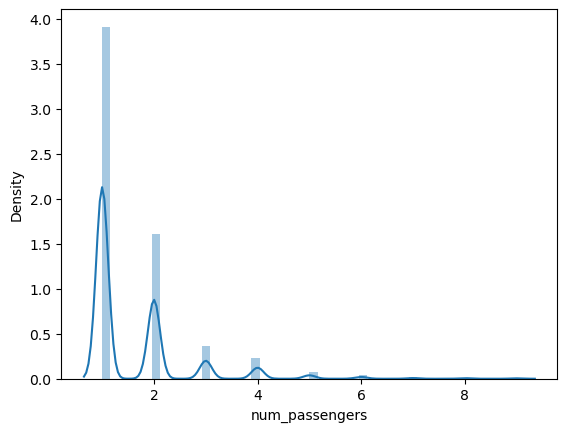

In [20]:
sns.distplot(df.num_passengers)
plt.show()

We can see that from the records, there is a high number of customers who are self travellers as compared to multiple travellers.

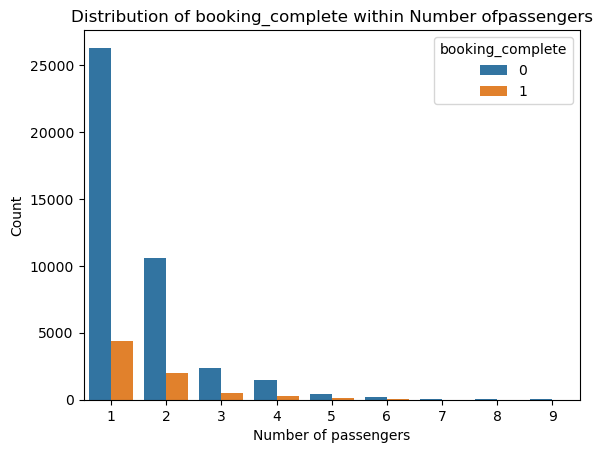

In [21]:
sns.countplot(x='num_passengers', hue='booking_complete', data=df)
plt.xlabel('Number of passengers')
plt.ylabel('Count')
plt.title('Distribution of booking_complete within Number ofpassengers')
plt.legend(title='booking_complete')
plt.show()

In [22]:
# Now lets check for percentage of completed and uncompleted bookings across various number of passengers
df1 = pd.crosstab(df.num_passengers, df.booking_complete, margins = True)
df1

booking_complete,0,1,All
num_passengers,,,
1,26285,4381,30666
2,10613,2026,12639
3,2392,484,2876
4,1489,273,1762
5,438,106,544
6,228,53,281
7,91,16,107
8,75,12,87
9,50,13,63


In [23]:
df1['percentage_successful_bookings'] = round(df1[1]*100/df1['All'],2)
df1['percentage_unsuccessful_bookings'] = round(df1[0]*100/df1['All'],2)
df1

booking_complete,0,1,All,percentage_successful_bookings,percentage_unsuccessful_bookings
num_passengers,,,,,
1,26285,4381,30666,14.29,85.71
2,10613,2026,12639,16.03,83.97
3,2392,484,2876,16.83,83.17
4,1489,273,1762,15.49,84.51
5,438,106,544,19.49,80.51
6,228,53,281,18.86,81.14
7,91,16,107,14.95,85.05
8,75,12,87,13.79,86.21
9,50,13,63,20.63,79.37


<Axes: xlabel='num_passengers'>

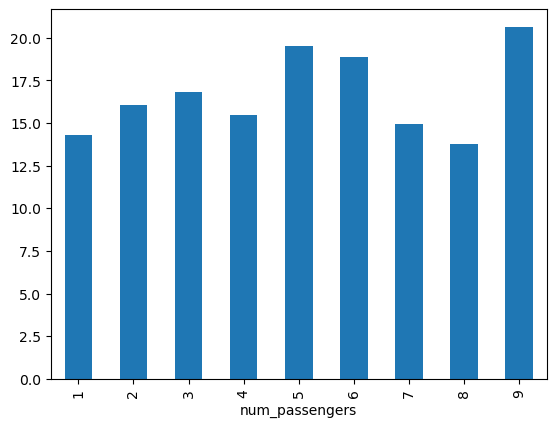

In [24]:
df1.drop('All', axis = 0).percentage_successful_bookings.plot(kind = 'bar')

We can now see that despite '1' number of passengers have the most occureence, customers with 9 passengers have the highest number of successful booking percentages. 

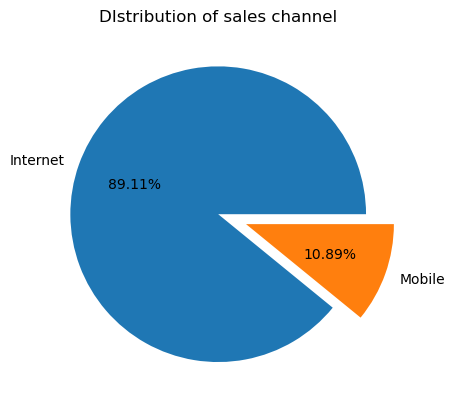

In [25]:
# Lets explore column sales_channel
plt.pie(df.sales_channel.value_counts().values, explode = [0,0.2], 
        labels = df.sales_channel.value_counts().index, autopct = '%.2f%%')
plt.title('DIstribution of sales channel')
plt.show()

We can see that we have more customers who use the internet channel compared to those who use the mobile channel. but lets try to investigate how the sales channel affect bookings.

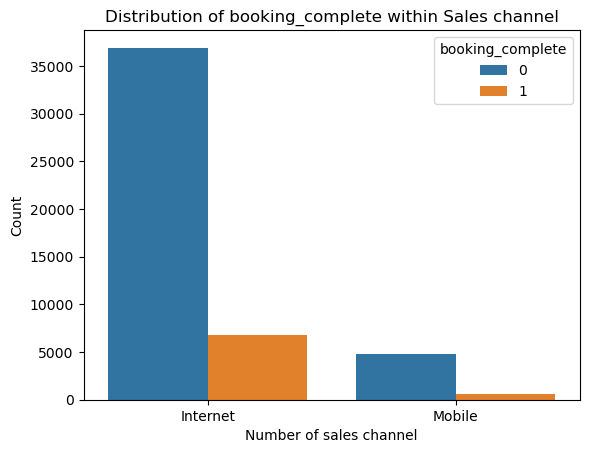

In [26]:
sns.countplot(x='sales_channel', hue='booking_complete', data=df)
plt.xlabel('Number of sales channel')
plt.ylabel('Count')
plt.title('Distribution of booking_complete within Sales channel')
plt.legend(title='booking_complete')
plt.show()

We can see that users of the internet channel completed more bookings completed to those using mobile, generally because of imbalance in the distribution of the sales channel. Now lets check for percentage comepleted booking ratio.

<Axes: xlabel='sales_channel'>

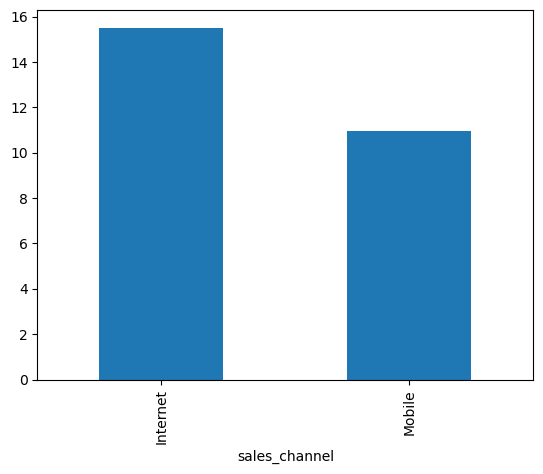

In [27]:
df2 = pd.crosstab(df.sales_channel, df.booking_complete, margins = True)
df2['percentage_successful_bookings'] = round(df2[1]*100/df2['All'],2)
df2.drop('All', axis = 0).percentage_successful_bookings.plot(kind = 'bar')

This shows that, on a percentage, Internet users completed more bookings as compared to Mobile users in terms of percentages.

In [28]:
# lets explore trip type
df.trip_type.value_counts()

RoundTrip     48526
OneWay          383
CircleTrip      116
Name: trip_type, dtype: int64

There is a very huge gap in the trip type, as round a large percentage of the customers opted for Round Trip.But that is not enough, lets investigate the percentage successful bookings of each trip type.

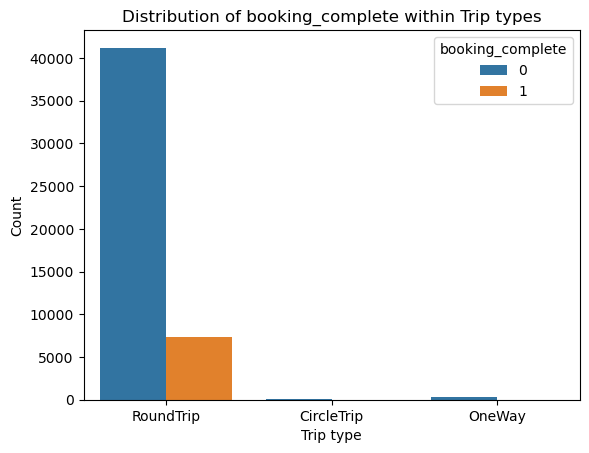

In [29]:
sns.countplot(x='trip_type', hue='booking_complete', data=df)
plt.xlabel('Trip type')
plt.ylabel('Count')
plt.title('Distribution of booking_complete within Trip types')
plt.legend(title='booking_complete')
plt.show()

<Axes: xlabel='trip_type'>

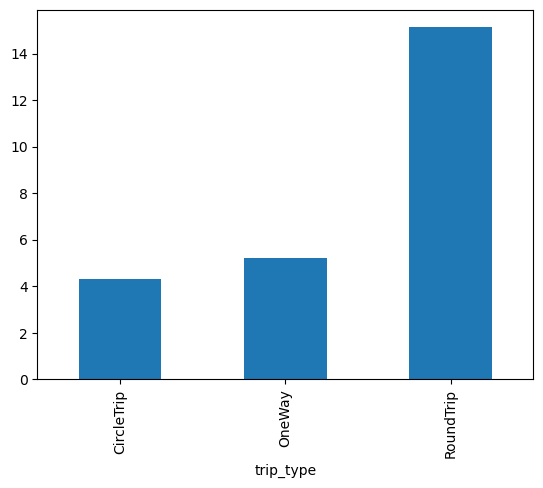

In [30]:
df3 = pd.crosstab(df.trip_type, df.booking_complete, margins = True)
df3['percentage_successful_bookings'] = round(df3[1]*100/df3['All'],2)
df3.drop('All', axis = 0).percentage_successful_bookings.plot(kind = 'bar')

We can say due to the imbalanced nature of the trip type, it resulted in Round trip having more completed booking percentage consequently because of its high volume in the dataset

C:\Users\elegb\AppData\Local\Temp\ipykernel_16456\3143740192.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.purchase_lead)


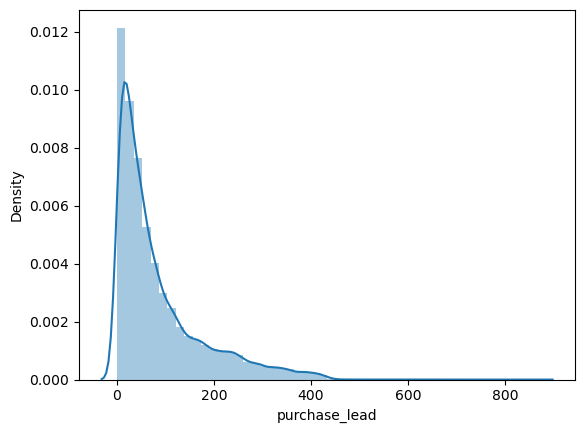

In [31]:
# lets explore purchase lead which is the number of days between travel date and booking date
sns.distplot(df.purchase_lead)
plt.show()

We can see that most of the records are between 0 to 200 days which means that most of the potential flight bookings have less purhase lead.

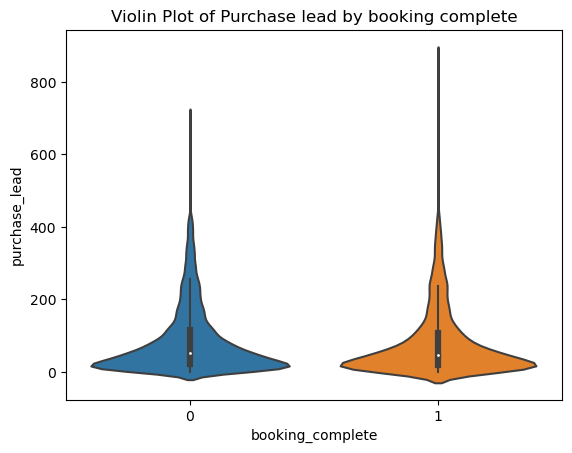

In [32]:
sns.violinplot(x='booking_complete', y='purchase_lead', data=df)
plt.title('Violin Plot of Purchase lead by booking complete')
plt.show()

We can see that the violin plot have similar shape, and almost same median. This generally implies that most of the bookings (succuessful and unsuccessful) have a less time lead. However,  there are instances where purchase lead extend longer for completed bookings and even uncompleted bookings.

C:\Users\elegb\AppData\Local\Temp\ipykernel_16456\1498700487.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.length_of_stay)


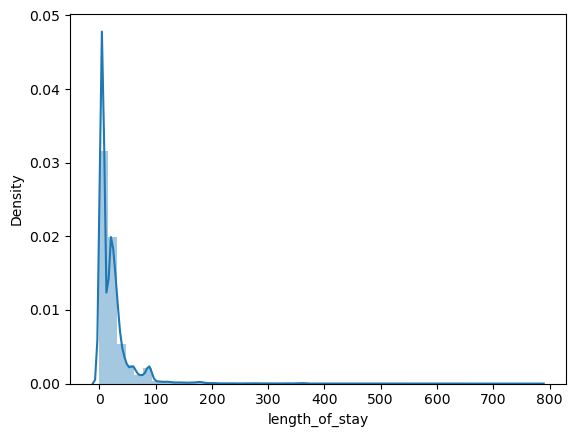

In [33]:
# Exploring length of stay and how it influence booking completion
sns.distplot(df.length_of_stay)
plt.show()

We can see that mostb of the customers are short stay travelllers.

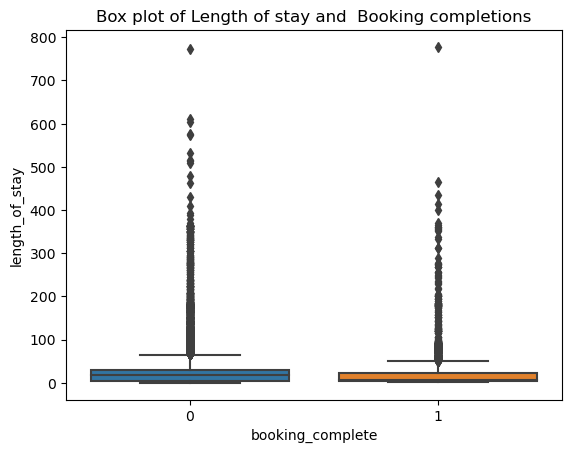

In [34]:
sns.boxplot(x = 'booking_complete', y = 'length_of_stay', data = df)
plt.title('Box plot of Length of stay and  Booking completions')
plt.show()

we can see that both customers that completed bookings and those who did not are clustered around less than 100 length of stays, This implies that most of the customers short time travellers .

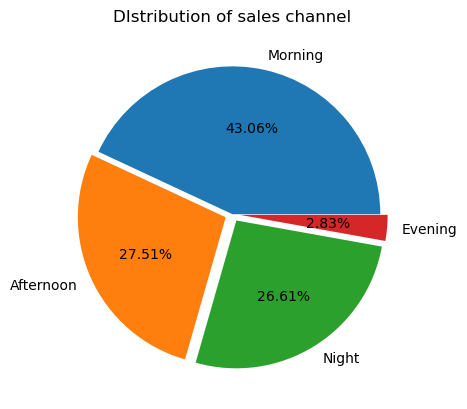

In [35]:
# period of day
plt.pie(df.period_of_day.value_counts().values, explode = [0,0.05, 0.05, 0.05], 
        labels = df.period_of_day.value_counts().index, autopct = '%.2f%%')
plt.title('DIstribution of sales channel')
plt.show()

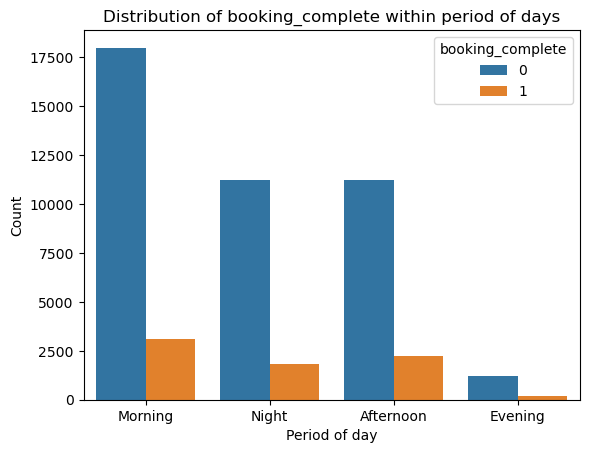

In [36]:
sns.countplot(x='period_of_day', hue='booking_complete', data=df)
plt.xlabel('Period of day')
plt.ylabel('Count')
plt.title('Distribution of booking_complete within period of days')
plt.legend(title='booking_complete')
plt.show()

<Axes: xlabel='period_of_day'>

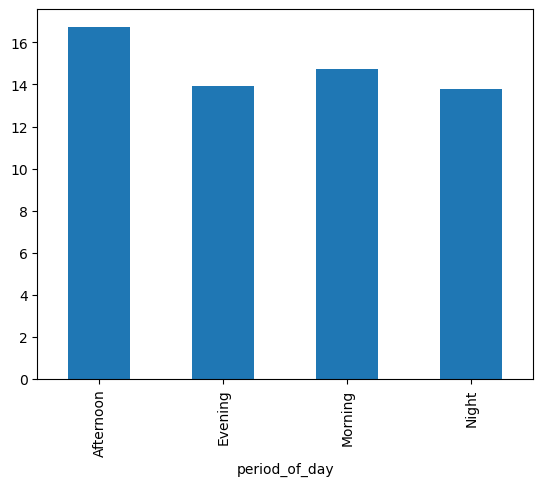

In [37]:
df4 = pd.crosstab(df.period_of_day, df.booking_complete, margins = True)
df4['percentage_successful_bookings'] = round(df4[1]*100/df4['All'],2)
df4.drop('All', axis = 0).percentage_successful_bookings.plot(kind = 'bar')

At just around approximately 17%, customers succesfully booked more during afternoon hours, closely followed by evening hours.

In [38]:
df.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_day', 'booking_origin', 'wants_extra_baggage',
       'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration',
       'booking_complete', 'period_of_day'],
      dtype='object')

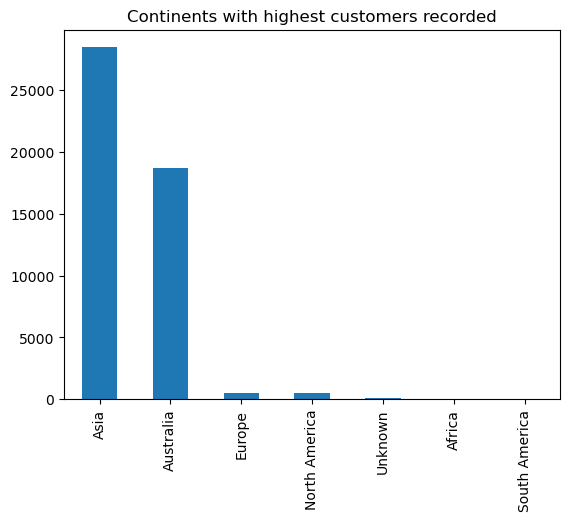

In [39]:
df.booking_origin.value_counts().plot(kind = 'bar')
plt.title('Continents with highest customers recorded')
plt.show()

This indicates that people located Australia and Asian continents are the most users of the airlines, but we cant be sure if they consequently have the highest successful booking percentage. 

<Axes: xlabel='booking_origin'>

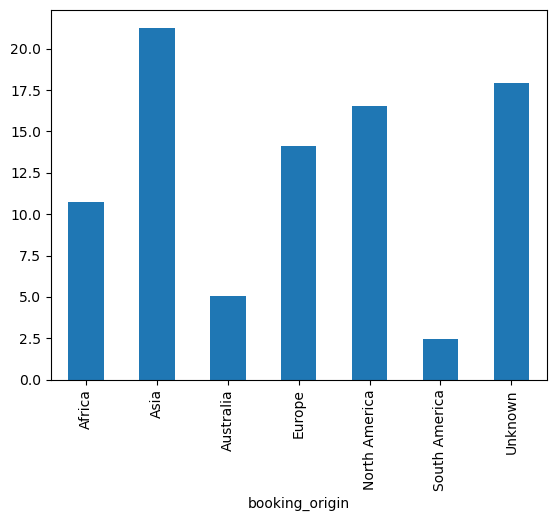

In [40]:
df5 = pd.crosstab(df.booking_origin, df.booking_complete, margins = True)
df5['percentage_successful_bookings'] = round(df5[1]*100/df5['All'],2)
df5.drop('All', axis = 0).percentage_successful_bookings.plot(kind = 'bar')

Booking origins fron Asia, had the highest succeful booking rate with over 20%, while Australia on the other hand, despite having high customers had a very low successful booking percentage which might be as a result of high flight fares from that region.

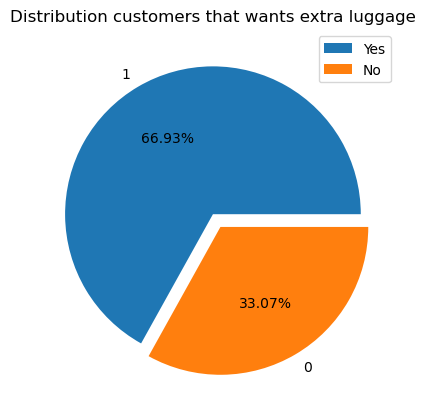

In [41]:
# exploring wants_extra_baggage feature
plt.pie(df.wants_extra_baggage.value_counts().values, explode = [0,0.1], 
        labels = df.wants_extra_baggage.value_counts().index, autopct = '%.2f%%')
plt.title('Distribution customers that wants extra luggage')
plt.legend(['Yes', 'No'])
plt.show()

This shows that approximately two-third of the entire customers will like to carry extra luggages,but lets see if this has an influence on booking completions.

<Axes: xlabel='wants_extra_baggage'>

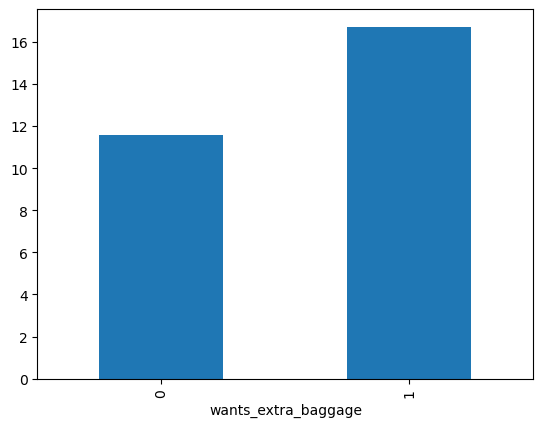

In [42]:
df6 = pd.crosstab(df.wants_extra_baggage, df.booking_complete, margins = True)
df6['percentage_successful_bookings'] = round(df6[1]*100/df6['All'],2)
df6.drop('All', axis = 0).percentage_successful_bookings.plot(kind = 'bar')

This shows that customers that wanted extra baggage have a slightly higher successful booking completion percentage compared to those who didn't, maybe due to cheap cost of extra baggages as compared to competitors ( we never could tell as we dont have information about prices whatsoever).

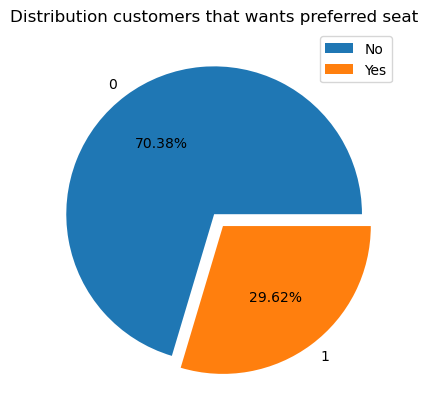

In [43]:
# wants_preferred_seat
plt.pie(df.wants_preferred_seat.value_counts().values, explode = [0,0.1], 
        labels = df.wants_preferred_seat.value_counts().index, autopct = '%.2f%%')
plt.title('Distribution customers that wants preferred seat')
plt.legend(['No', 'Yes'])
plt.show()

This shows that 70.38% of the customers didnt request for specific seats, but lets see if it affects booking completions.

<Axes: xlabel='wants_preferred_seat'>

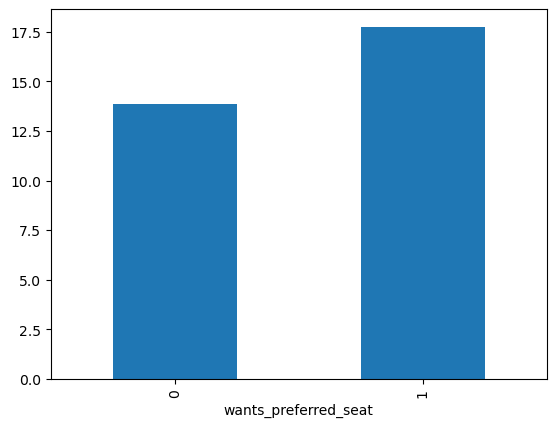

In [44]:
df7 = pd.crosstab(df.wants_preferred_seat, df.booking_complete, margins = True)
df7['percentage_successful_bookings'] = round(df7[1]*100/df7['All'],2)
df7.drop('All', axis = 0).percentage_successful_bookings.plot(kind = 'bar')

This shows that customers that wanted extra preferred seat have a slightly higher successful booking completion percentage compared to those who didn't request for preferred seat.

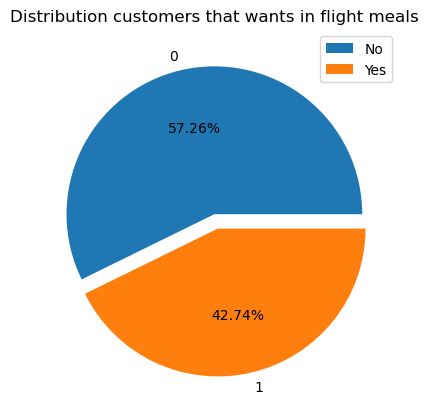

In [45]:
# wants_in_flight_meals
plt.pie(df.wants_in_flight_meals.value_counts().values, explode = [0,0.1], 
        labels = df.wants_preferred_seat.value_counts().index, autopct = '%.2f%%')
plt.title('Distribution customers that wants in flight meals')
plt.legend(['No', 'Yes'])
plt.show()

The percentage of customers who want in flight meals are much more than the percentage of customers who would like to get in flight meals

<Axes: xlabel='wants_in_flight_meals'>

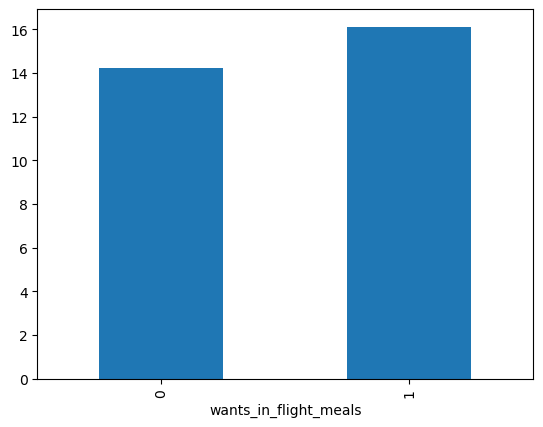

In [46]:
df8 = pd.crosstab(df.wants_in_flight_meals, df.booking_complete, margins = True)
df8['percentage_successful_bookings'] = round(df8[1]*100/df8['All'],2)
df8.drop('All', axis = 0).percentage_successful_bookings.plot(kind = 'bar')

Customers who wants in flight meals have more percentage of successful completions than those who don't want in flight meals.

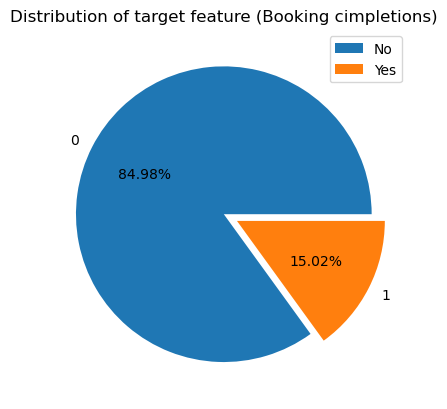

In [47]:
#booking complete
plt.pie(df.booking_complete.value_counts().values, explode = [0,0.1], 
        labels = df.booking_complete.value_counts().index, autopct = '%.2f%%')
plt.title('Distribution of target feature (Booking cimpletions)')
plt.legend(['No', 'Yes'])
plt.show()

We can see that only 15 percent of entire customers actually did booked the flight. This signifies an imbalanced class, we will trat the issue before modelling

In [48]:
#Lets change data types of some features
cat_columns = ['sales_channel', 'trip_type', 'flight_day',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'period_of_day']
df[cat_columns] = df[cat_columns].astype('category')

In [49]:
binary_features = ['sales_channel', 'wants_extra_baggage', 'wants_preferred_seat','wants_in_flight_meals']

In [50]:
#lets perform one hot encoding on some features
cat_class = ['trip_type', 'flight_day',
       'booking_origin','period_of_day']
cat_dummies = pd.get_dummies(df[cat_class])
cat_dummies

,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip,flight_day_1,flight_day_2,flight_day_3,flight_day_4,flight_day_5,flight_day_6,flight_day_7,...,booking_origin_Asia,booking_origin_Australia,booking_origin_Europe,booking_origin_North America,booking_origin_South America,booking_origin_Unknown,period_of_day_Afternoon,period_of_day_Evening,period_of_day_Morning,period_of_day_Night
0,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49020,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
49021,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
49022,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
49023,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [51]:
int_columns = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_duration']
# Normalise the int columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalised_data = scaler.fit_transform(df[int_columns])
normalised_df = pd.DataFrame(normalised_data, columns = int_columns)
normalised_df.head()

,num_passengers,purchase_lead,length_of_stay,flight_duration
0,0.125,0.302191,0.024422,0.175983
1,0.000,0.129181,0.025707,0.175983
2,0.125,0.280277,0.028278,0.175983
3,0.000,0.110727,0.039846,0.175983
4,0.125,0.078431,0.028278,0.175983


### Model Building

In [52]:
X = normalised_df.join(cat_dummies).drop('booking_origin_Unknown', axis=1)
X = X.join(df[binary_features])
y = df.booking_complete

In [53]:
mapping = {
    "Internet": 1,
    "Mobile": 2,
}

X["sales_channel"] = X["sales_channel"].map(mapping)

In [54]:
X.head()

,num_passengers,purchase_lead,length_of_stay,flight_duration,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip,flight_day_1,flight_day_2,flight_day_3,...,booking_origin_North America,booking_origin_South America,period_of_day_Afternoon,period_of_day_Evening,period_of_day_Morning,period_of_day_Night,sales_channel,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals
0,0.125,0.302191,0.024422,0.175983,0,0,1,0,0,0,...,0,0,0,0,1,0,1,1,0,0
1,0.000,0.129181,0.025707,0.175983,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,0.125,0.280277,0.028278,0.175983,0,0,1,0,0,1,...,0,0,1,0,0,0,1,1,1,0
3,0.000,0.110727,0.039846,0.175983,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,1
4,0.125,0.078431,0.028278,0.175983,0,0,1,0,0,1,...,0,0,1,0,0,0,1,1,0,1


In [55]:
y.value_counts()

0    41661
1     7364
Name: booking_complete, dtype: int64

In [56]:
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [57]:
X_resampled.isnull().sum()

num_passengers                    0
purchase_lead                     0
length_of_stay                    0
flight_duration                   0
trip_type_CircleTrip              0
trip_type_OneWay                  0
trip_type_RoundTrip               0
flight_day_1                      0
flight_day_2                      0
flight_day_3                      0
flight_day_4                      0
flight_day_5                      0
flight_day_6                      0
flight_day_7                      0
booking_origin_Africa             0
booking_origin_Asia               0
booking_origin_Australia          0
booking_origin_Europe             0
booking_origin_North America      0
booking_origin_South America      0
period_of_day_Afternoon           0
period_of_day_Evening             0
period_of_day_Morning             0
period_of_day_Night               0
sales_channel                   670
wants_extra_baggage             640
wants_preferred_seat            517
wants_in_flight_meals       

In [61]:
# since the data is highly imbalanced, lets replace the features with missing values with their modes.
columns = ['sales_channel', 'wants_extra_baggage','wants_preferred_seat','wants_in_flight_meals']

for column in columns:
    mode = X_resampled[column].mode()[0]
    X_resampled[column].fillna(mode, inplace = True)

X_resampled.isnull().sum()

num_passengers                  0
purchase_lead                   0
length_of_stay                  0
flight_duration                 0
trip_type_CircleTrip            0
trip_type_OneWay                0
trip_type_RoundTrip             0
flight_day_1                    0
flight_day_2                    0
flight_day_3                    0
flight_day_4                    0
flight_day_5                    0
flight_day_6                    0
flight_day_7                    0
booking_origin_Africa           0
booking_origin_Asia             0
booking_origin_Australia        0
booking_origin_Europe           0
booking_origin_North America    0
booking_origin_South America    0
period_of_day_Afternoon         0
period_of_day_Evening           0
period_of_day_Morning           0
period_of_day_Night             0
sales_channel                   0
wants_extra_baggage             0
wants_preferred_seat            0
wants_in_flight_meals           0
dtype: int64

In [62]:
# lets try logistic regression
logreg_model = LogisticRegression()

# Perform cross-validation
scores = cross_val_score(logreg_model, X_resampled, y_resampled, cv=5)

print("Cross-Validation Scores:", scores)
print("Mean CV Score:", np.mean(scores))

C:\Users\elegb\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\elegb\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Cross-Validation Scores: [0.66135873 0.67784268 0.67733675 0.678137   0.68013764]
Mean CV Score: 0.6749625607969216


C:\Users\elegb\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
# Fit the model on the training data
logreg_model.fit(X_resampled, y_resampled)

# Predict on the testing data
y_pred = logreg_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.598025618014196
Confusion Matrix:
[[5978 4442]
 [ 485 1352]]


C:\Users\elegb\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
# Generate classification report
class_report = classification_report(y_test, y_pred)

print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.57      0.71     10420
           1       0.23      0.74      0.35      1837

    accuracy                           0.60     12257
   macro avg       0.58      0.65      0.53     12257
weighted avg       0.82      0.60      0.66     12257



In [65]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
# Perform cross-validation
scores = cross_val_score(random_forest_model, X_resampled, y_resampled, cv=5)

print("Cross-Validation Scores:", scores)
print("Mean CV Score:", np.mean(scores))

Cross-Validation Scores: [0.71153077 0.92038089 0.92109475 0.92221511 0.92221511]
Mean CV Score: 0.8794873253575736


In [66]:
# Fit the model on the training data
random_forest_model.fit(X_resampled, y_resampled)

# Predict on the testing data
y_pred = random_forest_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print(class_report)

Accuracy: 0.7984009137635637
Confusion Matrix:
[[9445  975]
 [1496  341]]
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     10420
           1       0.26      0.19      0.22      1837

    accuracy                           0.80     12257
   macro avg       0.56      0.55      0.55     12257
weighted avg       0.77      0.80      0.78     12257



In [67]:
#Decison Tree
from sklearn.tree import DecisionTreeClassifier

In [68]:
decision_tree_model = DecisionTreeClassifier(random_state=42)
# Perform cross-validation
scores = cross_val_score(decision_tree_model, X_resampled, y_resampled, cv=5)

print("Cross-Validation Scores:", scores)
print("Mean CV Score:", np.mean(scores))

Cross-Validation Scores: [0.6195887  0.85900616 0.86163572 0.8584347  0.86363636]
Mean CV Score: 0.8124603297877278


In [69]:
# Fit the model on the training data
decision_tree_model.fit(X_resampled, y_resampled)

# Predict on the testing data
y_pred = decision_tree_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print(class_report)

Accuracy: 0.7374561475075467
Confusion Matrix:
[[8573 1847]
 [1371  466]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84     10420
           1       0.20      0.25      0.22      1837

    accuracy                           0.74     12257
   macro avg       0.53      0.54      0.53     12257
weighted avg       0.76      0.74      0.75     12257



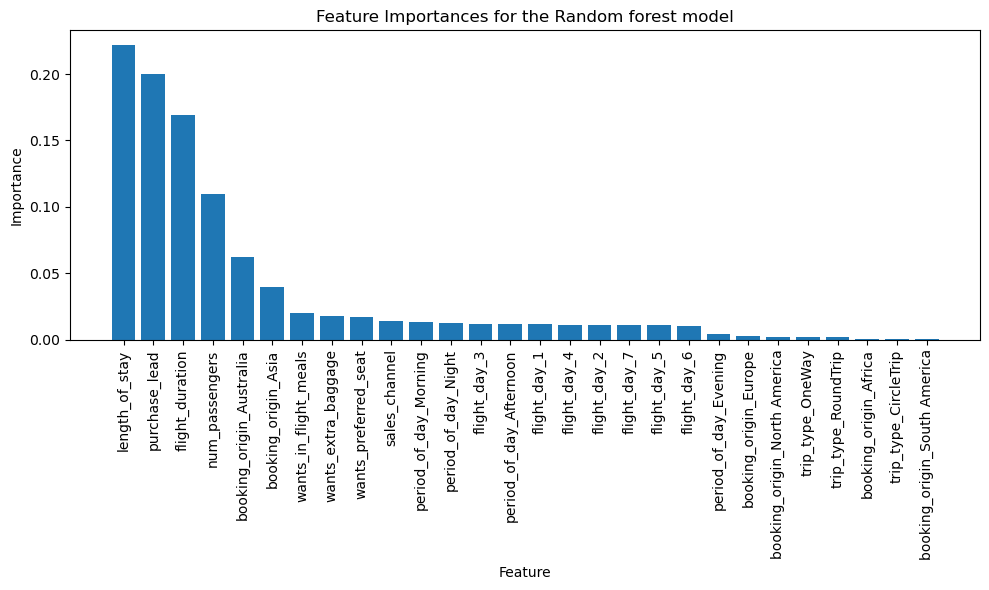

In [70]:
importances = random_forest_model.feature_importances_

# Get feature names
feature_names = X.columns

# Sort indices based on feature importances
sorted_indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[sorted_indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in sorted_indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances for the Random forest model")
plt.tight_layout()
plt.show()

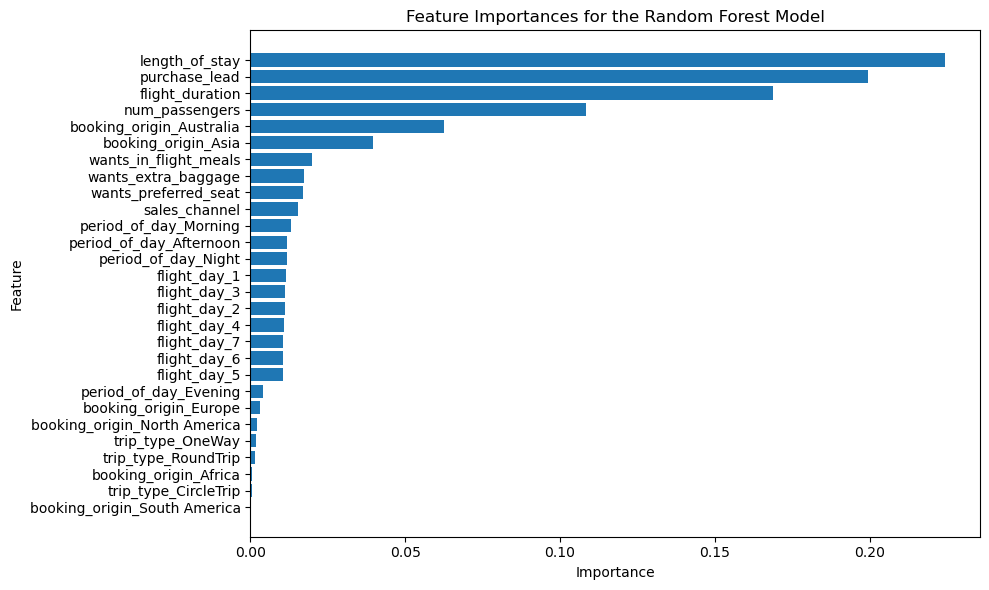

In [75]:
importances = random_forest_model.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances) 

plt.figure(figsize=(10, 6))
plt.barh(range(X.shape[1]), importances[sorted_indices])
plt.yticks(range(X.shape[1]), [feature_names[i] for i in sorted_indices])  
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.title("Feature Importances for the Random Forest Model")
plt.tight_layout()
plt.show()

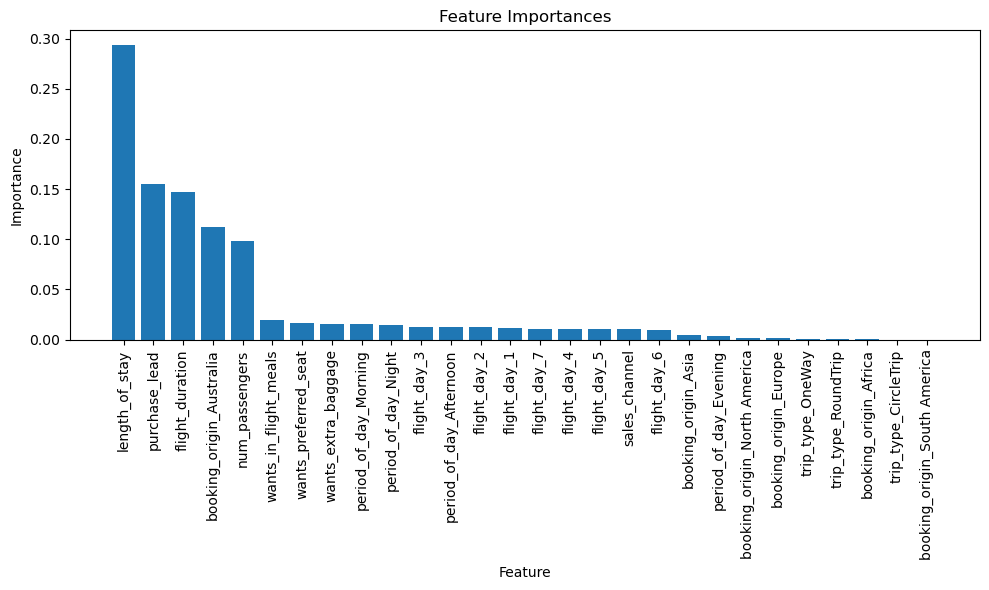

In [71]:
importances = decision_tree_model.feature_importances_

# Get feature names
feature_names = X.columns

# Sort indices based on feature importances
sorted_indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[sorted_indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in sorted_indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()